# Face mask detection
https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/
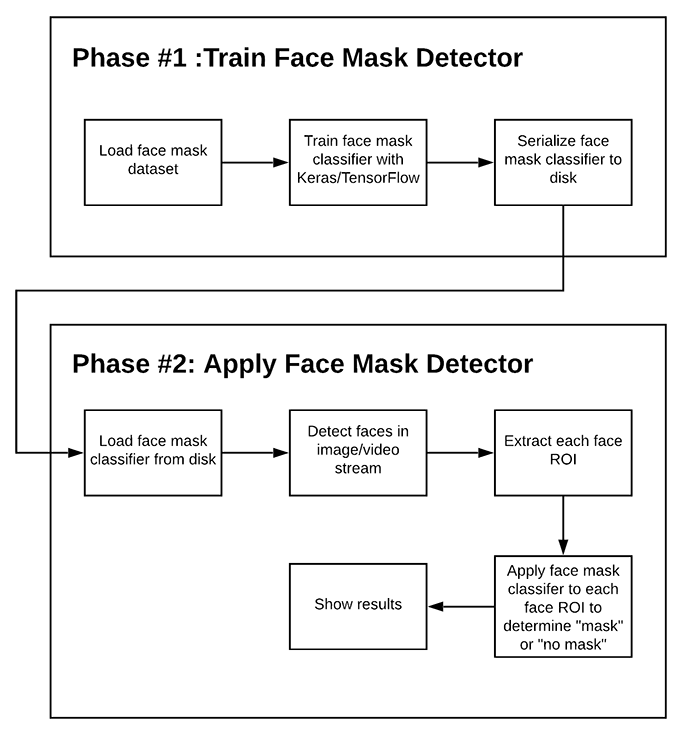

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

## Configuration

In [2]:
dataset_path = 'dataset/'  # Path to input dataset
model_path = 'mask_detector.model'  # Path to output face mask detector model

# Initialize the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

## Training

In [3]:
# Grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

# Loop over the image paths
for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # Load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # Update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
# Convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [4]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20,
                                                  stratify=labels, random_state=42)

# Construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, 
                         height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,
                         fill_mode="nearest")

In [5]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

/home/luis/.virtualenvs/cv/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [6]:
# Compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the head of the network
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 18s 532ms/step - loss: 0.6791 - accuracy: 0.6199 - val_loss: 0.3444 - val_accuracy: 0.8594
Epoch 2/20
34/34 [==============================] - 18s 525ms/step - loss: 0.3830 - accuracy: 0.8371 - val_loss: 0.2222 - val_accuracy: 0.9180
Epoch 3/20
34/34 [==============================] - 19s 551ms/step - loss: 0.3118 - accuracy: 0.8689 - val_loss: 0.1599 - val_accuracy: 0.9492
Epoch 4/20
34/34 [==============================] - 18s 534ms/step - loss: 0.2275 - accuracy: 0.9120 - val_loss: 0.1365 - val_accuracy: 0.9609
Epoch 5/20
34/34 [==============================] - 20s 585ms/step - loss: 0.1960 - accuracy: 0.9200 - val_loss: 0.0995 - val_accuracy: 0.9805
Epoch 6/20
34/34 [==============================] - 18s 526ms/step - loss: 0.1708 - accuracy: 0.9363 - val_loss: 0.0933 - val_accuracy: 0.9766
Epoch 7/20
34/34 [==============================] - 18s 533ms/step - loss: 0.1631 - accuracy: 0.94

## Validation

In [7]:
# Make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

# For each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Serialize the model to disk
model.save(model_path, save_format="h5")

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       138
without_mask       1.00      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



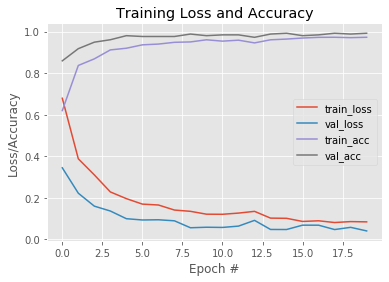

In [8]:
# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

# Face mask detection operation

## Configuration

In [9]:
image_path = ['examples/example_01.png', 'examples/example_02.png', 'examples/example_03.png']
face_detector = 'face_detector/'  # Path to face detector model directory
confidence = 0.5  # Minimum probability to filter weak detections

## Initialization

In [10]:
# Load our serialized face detector model from disk
prototxtPath = os.path.sep.join([face_detector, "deploy.prototxt"])
weightsPath = os.path.sep.join([face_detector, "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# Load the face mask detector model from disk
model = load_model(model_path)

## Detect mask

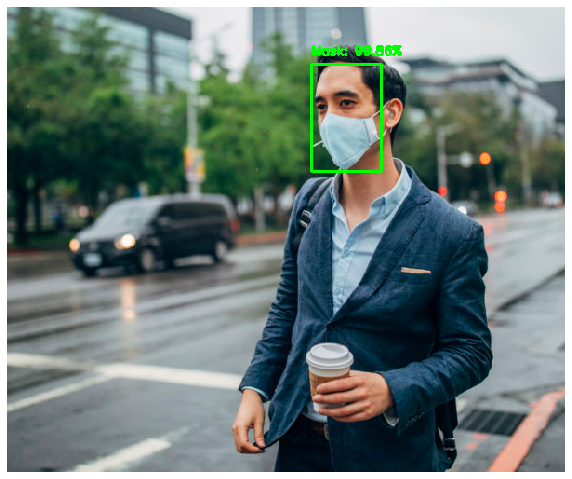

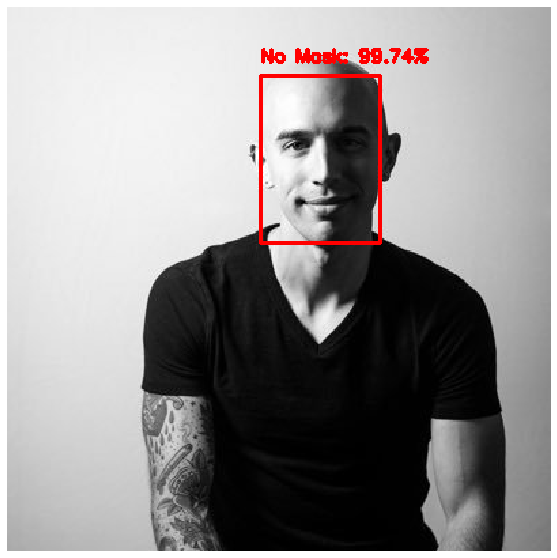

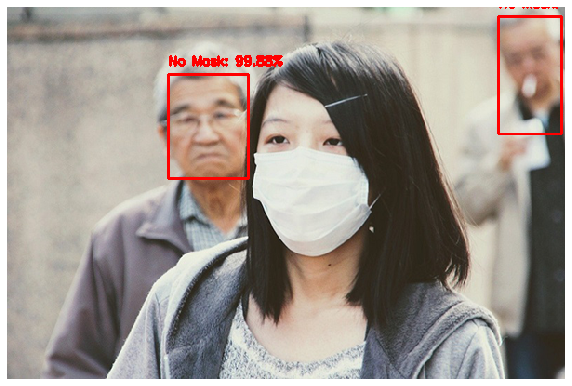

In [11]:
for path in image_path:
    # Load the input image from disk, clone it, and grab the image spatial dimensions
    image = cv2.imread(path)
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

    # Pass the blob through the network and obtain the face detections
    net.setInput(blob)
    detections = net.forward()

    # Loop over the detections
    for i in range(0, detections.shape[2]):
        # Extract the confidence (i.e., probability) associated with the detection
        conf = detections[0, 0, i, 2]

        # Filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if conf > confidence:
            # Compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Extract the face ROI, convert it from BGR to RGB channel ordering,
            # resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # Pass the face through the model to determine if the face has a mask or not
            (mask, withoutMask) = model.predict(face)[0]

            # Determine the class label and colour we'll use to draw the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            # Include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # Display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

    # show the output image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')